In [1]:
import numpy as np
from scipy.optimize import minimize
from groo.groo import get_root
import matplotlib.pyplot as plt
import pandas as pd
import sys, os
from groo.groo import get_root
rf = get_root(".hidden_root_mc")
sys.path.append(os.path.join(rf))

from models_and_funcs import *


PosixPath('/data/drive/postdoc/model-comparison-sims')

/tmp/ipykernel_54276/672250352.py:15: OptimizeWarning: Unknown solver options: verbose
  opt = minimize(fun=lklhd, x0=[50, 0.5], args=(rewards["Q"],other_data), method='Nelder-Mead', bounds=bnds, options={'verbose': 0})


Optimization terminated successfully.
[50.00001321  0.20000016]


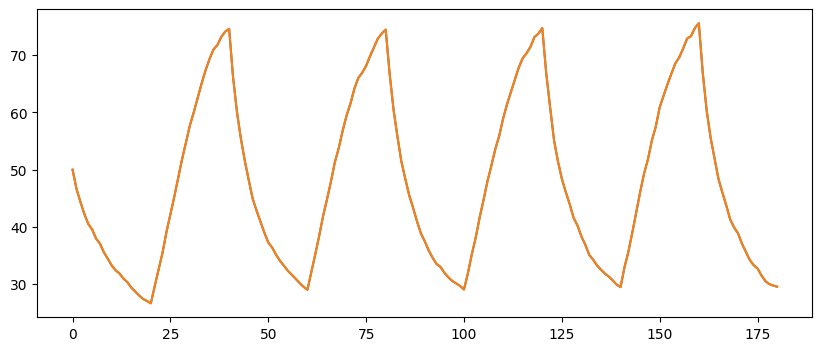

In [5]:

# Generate data 
N = 180
lvl = gen_states( lvls=[0,1], ch=20, n=N)
o = gen_states( lvls=[20,80], ch=20, n=N)+np.random.normal(0, 3, N)  
#other_data = {"o": o, "model": rw1, "state":lvl}

model = rw1_att
other_data = {"o": o, "model": model, "state":lvl}
rewards = model([50, 0.2], other_data)


# Fit data 
bnds = ((0,100),(0,1))
#bnds = ((0,100),(0,1),(0,1))
opt = minimize(fun=lklhd, x0=[50, 0.5], args=(rewards["Q"],other_data), method='Nelder-Mead', bounds=bnds, options={'verbose': 0})
print(opt.message)
print(opt.x)

# Look inside the model 
M = lklhd_m(opt.x, rewards["Q"],other_data)

f,ax=plt.subplots(1,1,figsize=(10,4))
ax.plot(rewards["Q"])
m1 = model(opt.x, other_data)
ax.plot(m1["Q"])

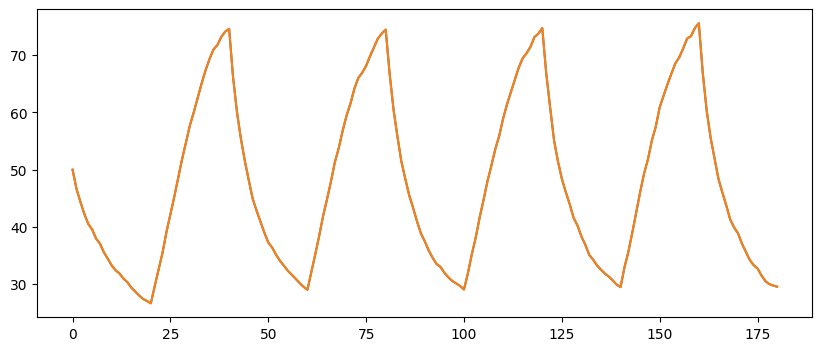

In [6]:
f,ax=plt.subplots(1,1,figsize=(10,4))
ax.plot(rewards["Q"])
m1 = model(opt.x, other_data)
ax.plot(m1["Q"])

## Noise levels

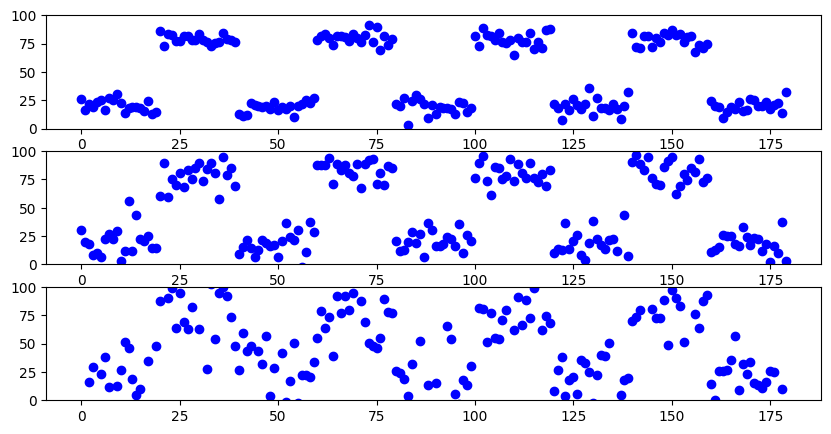

In [25]:
f, ax = plt.subplots(3,1, figsize=(10,5))
for i_idx, unc in enumerate([5, 10, 20]):
    o = gen_states( lvls=[20,80], ch=20, n=N)+np.random.normal(0, unc, N) 
    ax[i_idx].plot(o, 'bo')
    ax[i_idx].set_ylim([0,100])

 

### Do the actual procedure

In [7]:
N = 180
noise_level= [5, 10, 20]
cutoff = [90, 120, 150]
models = [rw1, rw2_val, rw2_state, rw4_val_state] 
model_names = ["rw1", "rw1_att", "rw2_val", "ph_basic"]
bounds = {"rw1": ((0,100),(0,1)),
          "rw1_att": ((0,100),(0,1)), 
          "rw2_val": ((0,100),(0,1),(0,1)),
          "ph_basic": ((0,100),(0,1),(0,1))}
df = pd.DataFrame()
for i_idx, noise in enumerate(noise_level):
    for c in cutoff:
        o_all = gen_states( lvls=[20,80], ch=20, n=N)+np.random.normal(0, noise, N) 
        lvl_all = gen_states( lvls=[0,1], ch=20, n=N)

        o = o_all[0:c]
        lvl = lvl_all[0:c]

        o_test = o_all[c:]
        lvl_test = lvl_all[c:]
        for ii in range(2):
            # split data 
            for m_idx, (m, mname) in enumerate(zip(models, model_names)): # loop over model GENERATING the data
                params_in = gen_rand_vals(bounds[mname])
                rewards = m(params_in, {"o": o_all, "model": m, "state":lvl_all})
                rew_test = rewards["Q"][c:]
                rewards["Q"] = rewards["Q"][0:c]


                # Fit data 
                AIC =[] 
                BIC = []
                AICc = [] 
                P = {}
                for mfit, mname_fit in zip(models, model_names):
                    other_data = {"o": o, "model": mfit, "state":lvl}
                    opt = minimize(fun=lklhd, x0=gen_rand_vals(bounds[mname_fit]), args=(rewards["Q"],other_data), method='COBYLA', bounds=bounds[mname_fit], options={'verbose': 0})
                    #print(opt.message)
                    #print(opt.x)

                    # Get IC 
                    M = lklhd_m(opt.x, rewards["Q"],other_data)
                    AIC.append(M["AIC"])
                    P[mname_fit] = opt.x
                    BIC.append(M["BIC"])
                    AICc.append(M["AICc"])
                
                # which model fit best
                best_idx =[np.argmin(AIC), np.argmin(AICc), np.argmin(BIC)]
                # is this the correct model
                #if aic_idx == m_idx:
                #    m_recovery_AIC = 1 # etc

                # get predictive error per trial of the best model
                pred_err = []
                for idxx, best in enumerate(best_idx):
                    other_data = {"o": o_test, "model": models[best_idx[idxx]], "state":lvl_test}
                    Mbest = lklhd_m(P[model_names[best_idx[idxx]]], rew_test, other_data)
                    pred_err.append(Mbest["err_per_n"])

                # Gather data
                D = {"noise": noise, "cutoff":c, "true_model": mname, 
                    "best_model_AIC": model_names[best_idx[0]], 
                    "best_model_AICc": model_names[best_idx[1]],  
                    "best_model_BIC": model_names[best_idx[2]], 
                    "mean_err_AIC": pred_err[0],
                    "mean_err_AICc": pred_err[1],
                    "mean_err_BIC": pred_err[2]               
                    }
                dfrow = pd.DataFrame.from_dict(D, orient="index").T
                df = pd.concat([df, dfrow], axis=0)


df.to_csv("model_comparison.csv")      

/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: verbose
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,
/tmp/ipykernel_201003/1189792414.py:79: RuntimeWarning: divide by zero encountered in log
  lklhd = -np.log(cp[1]-cp[0])
/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: verbose
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,
/tmp/ipykernel_201003/11897

In [ ]:
for idxx, best in enumerate(best_idx):
    other_data = {"o": o_test, "model": models[best_idx[idxx]], "state":lvl_test}
    Mbest = lklhd_m(P[model_names[best_idx[idxx]]], rew_test, other_data)
    pred_err.append(Mbest["err_per_n"])